# **Вариант 1**

**Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:**

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации
- reg_ts	
- uid

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру
- auth_ts	
- uid

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import pingouin as pg
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import norm
from scipy.stats import chi2_contingency, chi2 

%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Импортируем данные
df_registrations = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-salmanova/shared/problem1-reg_data.csv', sep=';') # таблица с уникальными идентификаторами пользователей
df_autorizations = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-salmanova/shared/problem1-auth_data.csv', sep=';') # таблица с уникальными идентификаторами пользователей

In [3]:
# Изучим два датасета
# Посмотрим на типы данных:
print(format(df_registrations.dtypes))
print(format(df_autorizations.dtypes))

reg_ts    int64
uid       int64
dtype: object
auth_ts    int64
uid        int64
dtype: object


In [4]:
# Посчитаем число уникальных значений для каждой колонки:
print(format(df_registrations.nunique()))
print(format(df_autorizations.nunique()))

reg_ts    1000000
uid       1000000
dtype: int64
auth_ts    9180915
uid        1000000
dtype: int64


In [5]:
# Посчитаем временной промежуток регистраций
print('MIN -', datetime.utcfromtimestamp(df_registrations.reg_ts.min()).strftime('%Y-%m-%d'))
print('MAX -', datetime.utcfromtimestamp(df_registrations.reg_ts.max()).strftime('%Y-%m-%d'))

MIN - 1998-11-18
MAX - 2020-09-23


В наших таблицах данные с ноября 1998г по сентябрь 2020. Мы можем сразу сказать, что временной промежуток одинаковый, тк кол-во уникальых пользователей совпадает и объединение можно делать именно по этой колонке без задвоений.
В датасете df_registrations все пользователи - уникальны и встречаются только 1 раз. В датасете df_autorizations представлены все те же пользователи, как и в df_registrations, однако некоторые заходили в приложение более 1 раза, так как кол-во уникальных пользователей = 1000000, а число уникальных строк с временем захода пользователя в игру равно 9180915.

Retention - коэффициент удержания клиентов. Показывает, насколько хорошо компания выстраивает долгосрочные отношения с клиентами.
- Расчитываем Retention от заданной даты до конца необходимого периода. 
- Нужно будет ввести дату начала и продолжительность. 
- Для всех выбранных дат рассчитаем Retention в заданном промежутке.

In [6]:
def getting_retention_by_period(df_registrations, df_autorizations, start_date, period):
    # date_first  - дата начала 
    # date_last - дата окончания 
    # file_of_registrations - файл с регистрациями
    # file_of_autorizations - файл с заходами в игру
    
    start_date = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    finish_date = (pd.to_datetime(start_date) + pd.Timedelta(days=period)).strftime('%Y-%m-%d')
    
    # объединяем файлы в один по номеру пользователя
    df_all = df_autorizations.merge(df_registrations, on='uid')
    # вводим столбцы с корректным для анализа отображением дат
    df_all['registration_date'] = pd.to_datetime(df_all.reg_ts, unit='s').apply(lambda x: x.strftime('%Y-%m-%d'))
    df_all['autorization_date'] = pd.to_datetime(df_all.auth_ts, unit='s').apply(lambda x: x.strftime('%Y-%m-%d'))
    df_all['registration_date'] = pd.to_datetime(df_all['registration_date'])
    df_all['autorization_date'] = pd.to_datetime(df_all['autorization_date'])
    # удаляем лишние столбцы
    df_all = df_all.drop(['reg_ts', 'auth_ts'], axis=1)
    #  вводим столбец где посчитаем сколько дней прошло с момента регистрации до конкретного захода
    df_all['lifetime'] = ((df_all['autorization_date'] - df_all['registration_date'])/np.timedelta64(1, 'D')).round().astype(int)
    
    # Оставляем данные только с необходимым для анализа временным промежутком
    df_necessary_dates = df_all[(df_all['registration_date'] >= start_date) & (df_all['autorization_date'] <= finish_date) & (df_all['lifetime'] <= period)]
    # Группируем данные по дате регистрации и дням с момента регистрации, считаем количество уникальных пользователей
    cohort_data = df_necessary_dates.groupby(['lifetime','registration_date'])['uid'].apply(pd.Series.nunique).reset_index()
    # Считаем retention и выводим его в отдельную таблицу
    retention = cohort_data.pivot_table(index='registration_date', columns='lifetime', values='uid')
    retention = retention.divide(retention.iloc[:,0],axis=0).fillna(0).round(3)
    
    # Визуализируем данные
    plt.figure(figsize=(17, 8))
    ax = sns.heatmap(retention, cmap="YlGnBu", annot=True, fmt=".1%", vmax=0.1)
    ax.set_title('Retention Rate {} days from {}'.format(period, start_date), fontsize=30)
    sns.despine()
    
    
    return retention

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
registration_date,,,,,,,,,,,,,,,,
2020-09-01,1.0,0.020,0.041,0.042,0.046,0.064,0.056,0.064,0.041,0.054,0.051,0.054,0.049,0.055,0.043,0.044
2020-09-02,1.0,0.025,0.039,0.047,0.057,0.062,0.071,0.063,0.048,0.041,0.057,0.055,0.055,0.043,0.050,0.000
2020-09-03,1.0,0.023,0.054,0.047,0.065,0.070,0.085,0.063,0.055,0.063,0.063,0.055,0.058,0.060,0.000,0.000
2020-09-04,1.0,0.020,0.036,0.036,0.051,0.064,0.073,0.050,0.053,0.043,0.056,0.055,0.043,0.000,0.000,0.000
2020-09-05,1.0,0.028,0.039,0.046,0.055,0.059,0.075,0.049,0.051,0.055,0.060,0.052,0.000,0.000,0.000,0.000
2020-09-06,1.0,0.031,0.043,0.054,0.056,0.059,0.068,0.061,0.058,0.055,0.049,0.000,0.000,0.000,0.000,0.000
2020-09-07,1.0,0.029,0.042,0.054,0.051,0.064,0.073,0.052,0.041,0.056,0.000,0.000,0.000,0.000,0.000,0.000
2020-09-08,1.0,0.017,0.039,0.039,0.049,0.076,0.075,0.066,0.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2020-09-09,1.0,0.017,0.032,0.047,0.057,0.067,0.057,0.059,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


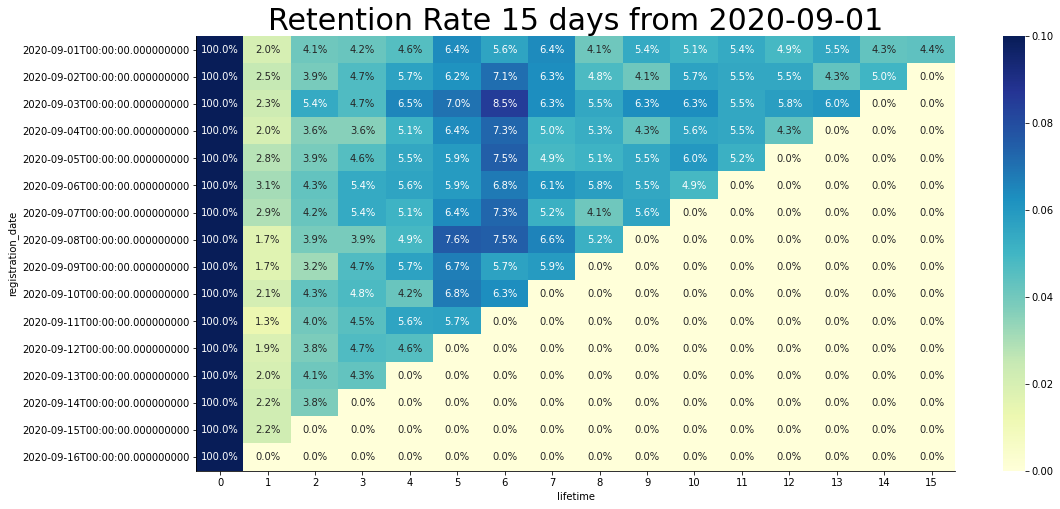

In [7]:
# Проверяем функцию. Условия: дата - 2019-01-01, промежуток - 15 дней
getting_retention_by_period(df_registrations, df_autorizations, '2020-09-01', 15)

Здесь мы видим уровни удержания пользователей в течение 15-дневного периода, начиная с 1го сентября 2020 года.
- Первоначальное удержание после регистрации (день 0) составляет 100%, что очевидно, тк все пользователи учитываются в день их регистрации.
- Самые высокие уровни удержания после первого дня наблюдаются у пользователей, зарегистрировавшихся 3, 4 и 9 сентября. У этих дат удержание на второй день выше 3%.

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Формат данных:

In [8]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-salmanova/final_project/2.csv', sep=';')
df.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [9]:
# user_id - идентификатор пользователя
# revenue - выручка на пользователя
# testgroup - группа пользователей
# а - контрольная
# b- тестовая (с изменениями)

In [10]:
# Сделаем анализ данных
# Типы данных
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [11]:
# Посчитаем число уникальных значений:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [12]:
# Посчитаем общее количество строк и столбцов: 
df.shape

(404770, 3)

In [13]:
# Посчитаем минимальную и максимальную выручку:
print('MIN -', df.revenue.min())
print('MAX -', df.revenue.max())

MIN - 0
MAX - 37433


In [14]:
# Посмотрим сколько уникальных пользователей в каждой из групп:
df.groupby('testgroup', as_index = False)[['user_id']].nunique()

,testgroup,user_id
0,a,202103
1,b,202667


In [15]:
# Посчитаем число платящих пользователей в двух группах:
df.query("revenue > 0").groupby('testgroup', as_index = False)[['user_id']].nunique()

,testgroup,user_id
0,a,1928
1,b,1805


- Есть 2 тестовых группы (а и b)
- Уникальные значения = 404770 = кол-во строк => В датасете нет повторяющихся пользователей.
- Показатель revenue начинается с 0, значит в этом столбце нет отрицательных значений, которые могли бы привести к некорректным данным.
- В a 202103 пользователей, а в b 202667 пользовтелей => +- одинаково, можем проводить тесты дальше.
- А тут встает вопрос, тк в группе а 1928 платящих пользователей, в группе b 1805 платящих пользователелей. Обратим внимание дальше на показатель СTR, тк он вероятно довольно сильно отличается в группах.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [16]:
df.query('testgroup == "a" ').describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [17]:
df.query('testgroup == "b" ').describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [18]:
df.query('testgroup == "a" & revenue > 0').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [19]:
df.query('testgroup == "b" & revenue > 0').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Изучим распределение дохода всех пользователей и заплативших пользователей в каждой из групп

Cреди заплативших пользователей в группе a:
- среднее и медианное значение сильно отличаются
- стандартное отклонение = 9049 (большой разброс значений)
Cреди заплативших пользователей в группе b:
- среднее и медианное значение примерно равны 


Для всех пользователей между группами:
- Средние значения выручки примерно одинаковы
- Стандартное отклонение и максимальное значение выручки сильно различаются.

На основе выше проведенного анализа выборки кажутся нерепрезентативными и распределение платежей не подходит под нормальное. Проверим это в дальнейших тестах.

**Метрики**
- ARPU - средний доход с каждого пользователя (ARPU = Доход/Кол-во пользователей).
- ARPPU -  средний доход с каждого заплатившего пользователя (ARPPU = Доход/Кол-во клиентов).
- CR - доля пользователей, которые совершили платеж (СR = Кол-во клиентов/Кол-во пользователей)

In [20]:
df_users = df.groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'users'}) 
df_clients = df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'clients'})
df_revenue = df.groupby('testgroup', as_index=False).agg({'revenue':'sum'}) 

In [21]:
df_all = df_users.merge(df_clients, on = 'testgroup').merge(df_revenue, on = 'testgroup')

In [22]:
df_all['ARPU'] = (df_all.revenue/df_all.users).round(2)
df_all['ARPPU'] = (df_all.revenue/df_all.clients).round(2)
df_all['CR'] = (df_all.clients/df_all.users*100).round(2)
df_all

,testgroup,users,clients,revenue,ARPU,ARPPU,CR
0,a,202103,1928,5136189,25.41,2664.00,0.95
1,b,202667,1805,5421603,26.75,3003.66,0.89


Что мы сразу видим?
- В тестовой группе было задействовано больше пользователей 
- В тестовой группе общая сумма всех покупок увеличилась
- В тестовой группе выше средний доход на пользователя
- В тестовой группе значительно выше средних доход на платящего пользователя
- В контрольной группе число заплативших пользователей выше
- В контрольной группе конверция в клиента больше 

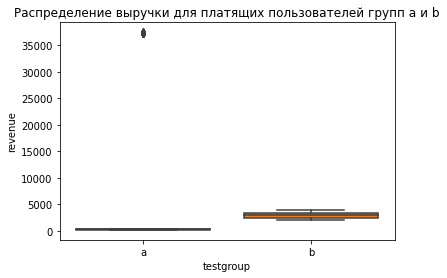

In [23]:
# Построим распределение выручки пользователей для двух групп:
plt.title('Распределение выручки для платящих пользователей групп a и b')
ax = sns.boxplot(data = df.query("revenue > 0"), x = 'testgroup', y = 'revenue')

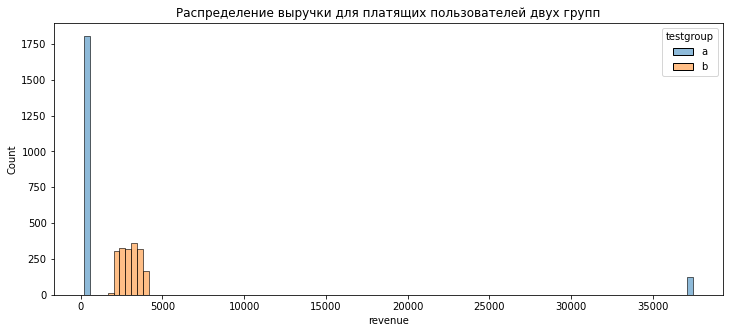

In [24]:
# Построим распределение выручки пользователей для двух групп:
plt.figure(figsize=(12, 5))
plt.title('Распределение выручки для платящих пользователей двух групп')
sns.histplot(data = df.query("revenue > 0"), x='revenue', hue='testgroup')

Распределения выручки для двух групп кардинально различаются между собой. В группе а имеются большие выбросы

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

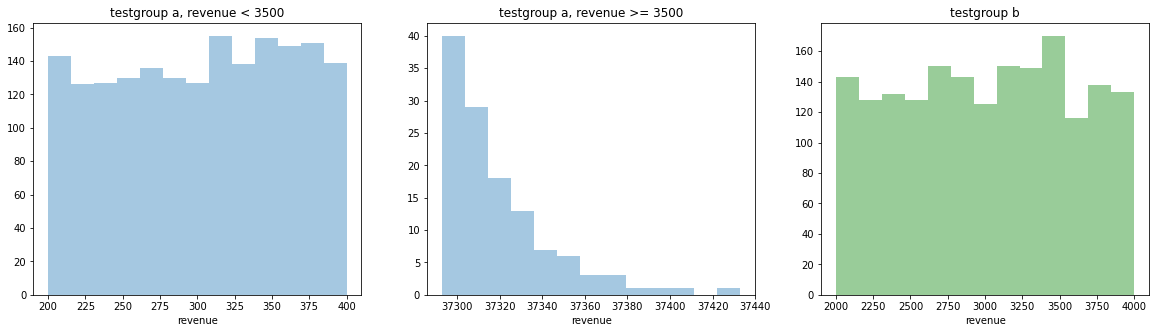

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(df.query('revenue != 0 & testgroup == "a" & revenue < 3500').revenue, kde=False, ax=ax[0]).set_title('testgroup a, revenue < 3500')
sns.distplot(df.query('revenue != 0 & testgroup == "a" & revenue >= 3500').revenue, kde=False, ax=ax[1]).set_title('testgroup a, revenue >= 3500')
sns.distplot(df.query('revenue != 0 & testgroup == "b"').revenue, kde=False, ax=ax[2], color = 'green').set_title('testgroup b')


plt.show()

Как мы и предполагали, распределение визуально не выглядит нормальным.     

In [26]:
df_a = df.query('testgroup == "a"')
df_b = df.query('testgroup == "b"')

In [27]:
# Проверим это с помощью критерия Шапиро-Уилка.
df_a_revenue = df_a.query('revenue > 0')
stat, p = ss.shapiro(df_a_revenue['revenue'])
stat, p

(0.2667924761772156, 0.0)

Н0: распределение данных нормальное
p-value = 0.0 < 0.05 => Отклоняем гипотезу

In [28]:
df_b_revenue = df_b.query('revenue > 0')
stat, p = ss.shapiro(df_b_revenue['revenue'])
stat, p

(0.9583123922348022, 2.491345674771425e-22)

Н0: распределение данных нормальное
p-value = 0.0 < 0.05 => Отклоняем гипотезу

In [29]:
# Для допольнительной проверки используем критерий Манна-Уитни
ss.mannwhitneyu(df_a_revenue.revenue, df_b_revenue.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value = 0.0 < 0.05 => Отклоняем гипотезу
- После двух тестов делаем вывод => 
- Распределение - не нормальное =>
- Применяем метод бутстрап

In [30]:
# Проверим, являются ли эти различия статистически значимы, или нет.
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [31]:
df_bootstrap = df.copy()

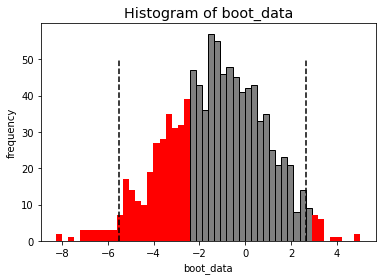

0.5485233461903165

In [32]:
ARPU_bootstrap = get_bootstrap(df_a.revenue, df_b.revenue)
ARPU_bootstrap['p_value']

- ARPU : Н0: в группах нет статистически значимых различий
- Значение p_value > 0.05
- 0 лежит между доверительными границами =>
- Отклонить нулевую гипотезу мы не можем =>
- Статистически значимых различий нет.

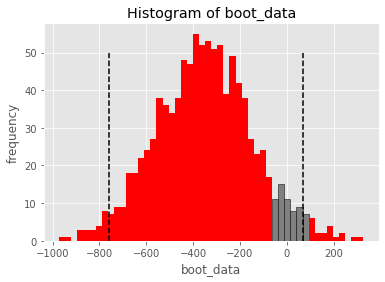

0.08755093743763534

In [33]:
ARPPU_bootstrap = get_bootstrap(df_a_revenue.revenue, df_b_revenue.revenue)
ARPPU_bootstrap['p_value']

-  ARPPU : Н0: в группах нет статистически значимых различий
- p-value > 0.05
- 0 лежит между доверительными границами 
=> Статистически значимых различий нет.

In [34]:
df_alls = df_all.set_index('testgroup')
df_CR = df_alls[['users', 'clients']]
df_CR

,users,clients
testgroup,,
a,202103,1928
b,202667,1805


In [35]:
# C помощью критерия хи-квадрат проверим равны ли распределения 
stat, p, dof, expected = chi2_contingency(df_CR)
stat, p

(4.294148751290091, 0.03824373651044168)

- СR : H0: В группах нет статистически значимых различий и взаимосвязи между переменными нет
- p-value < 0.05 =>
- Отклоняем гипотезу Н0
- CR группы a статистически значимо больше, чем CR группы b

Вывод по заданию 2:
 
Для принятия решения были проанализированы метрики ARPU, ARPPU, CR. Статистически значимых отличий по метрикам ARPU и ARPPU не обнаружено. Но в случае с СR - выявлены статистически значимые различия между группами. В группе a наблюдается увеличение CR по сравнению с группой b, при этом средняя выручка не изменилась => акционные предложения в группе a лучше по сравнению с группой b.

Рекомендации:
Тк в группе а достаточно высокие выбросы (либо нет покупок, либо малое кол-во пользователей с крупным чеком), а в b все покупки лежат в среднем диапазоне, стоит пересплитовать данные, сделать А/А тест и только потом проводить на А/Б тест.  А так же провести более детальный анализ плательщиков с крупным чеком.

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Метрики:
1. MAU / WAU / DAU - это количество уникальных пользователей, которые зашли в приложение в течение месяца, недели, суток. Опрелеляем интерес пользователя.

2. Sticky Factor = DAU/MAU — показатель лояльности аудитории к приложению. Отследим, как часто пользователи возвращаются в приложение.

3. Time spent / AVG Time spent / - время, которое пользователь провел в приложении/среднее время сессий за период времени. 
4. Количество сеансов (сессий) на пользователя за месяц. Поймем, насколько актуально наше приложение для пользователя и есть ли сезонности по дате.

5. CR (Conversion Rate) - конверсия уникальных игроков в платящих. Узнаем, стимулирует ли теематическое событие пользователей покупать продукт.

6. NewUsers - доля новых пользователей, пришедших через ивент.
7. Has_bonus - получал или нет уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Сможем сравнить метрики и узнать, на какие из влияют бонусы.
8. Retention Rate - процент клиентов, которые возвращаются в приложение. Оценим процент возвращения юзеров после их участия в ивенте. Если падает = модернизируем событие, тк возможно слишком сложно получить призы.
9. ARPU / ARPPU - средний доход в месяц с привлеченного пользователя / клиента (платящего пользователя). Узнаем, как повлияло событе на увеличение средней доходности от пользователей.

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Все тоже самое +
- Параметр : Был ли откат. Сравним другие метрики, учитывая параметр, и узнаем какое действие оказывает.
- Отток пользователей - Узнаем, сколько пользователей уходят при откате.
- Лояльность пользователей - Узнаем, сколько пользователей продолжают играть при откате.
- Максимальное кол-во откатов - Выявим самый сложный уровень, где происходят откаты.